# AdaDelta算法

除了RMSProp算法以外，另一个常用优化算法AdaDelta算法也针对AdaGrad算法在迭代后期可能较难找到有用解的问题做了改进 [1]。有意思的是，AdaDelta算法没有学习率这一超参数。

## 算法

AdaDelta算法也像RMSProp算法一样，使用了小批量随机梯度$\boldsymbol{g}_t$按元素平方的指数加权移动平均变量$\boldsymbol{s}_t$。在时间步0，它的所有元素被初始化为0。给定超参数$0 \leq \rho < 1$（对应RMSProp算法中的$\gamma$），在时间步$t>0$，同RMSProp算法一样计算

$$\boldsymbol{s}_t \leftarrow \rho \boldsymbol{s}_{t-1} + (1 - \rho) \boldsymbol{g}_t \odot \boldsymbol{g}_t. $$

与RMSProp算法不同的是，AdaDelta算法还维护一个额外的状态变量$\Delta\boldsymbol{x}_t$，其元素同样在时间步0时被初始化为0。我们使用$\Delta\boldsymbol{x}_{t-1}$来计算自变量的变化量：

$$ \boldsymbol{g}_t' \leftarrow \sqrt{\frac{\Delta\boldsymbol{x}_{t-1} + \epsilon}{\boldsymbol{s}_t + \epsilon}}   \odot \boldsymbol{g}_t, $$

其中$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-5}$。接着更新自变量：

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}'_t. $$

最后，我们使用$\Delta\boldsymbol{x}_t$来记录自变量变化量$\boldsymbol{g}'_t$按元素平方的指数加权移动平均：

$$\Delta\boldsymbol{x}_t \leftarrow \rho \Delta\boldsymbol{x}_{t-1} + (1 - \rho) \boldsymbol{g}'_t \odot \boldsymbol{g}'_t. $$

可以看到，如不考虑$\epsilon$的影响，AdaDelta算法与RMSProp算法的不同之处在于使用$\sqrt{\Delta\boldsymbol{x}_{t-1}}$来替代超参数$\eta$。


## 从零开始实现

AdaDelta算法需要对每个自变量维护两个状态变量，即$\boldsymbol{s}_t$和$\Delta\boldsymbol{x}_t$。我们按AdaDelta算法中的公式实现该算法。

In [1]:
%matplotlib inline
import d2ltorch as d2lt
import torch
from torch import optim

features, labels = d2lt.get_data_ch7()

def init_adadelta_states():
    s_w, s_b = torch.zeros(features.shape[1], 1), torch.zeros(1)
    delta_w, delta_b = torch.zeros(features.shape[1], 1), torch.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        s.data = rho * s.data + (1 - rho) * (p.grad.data ** 2)
        g = ((delta.data + eps).sqrt() / (s.data + eps).sqrt()) * p.grad.data
        p.data -= g.data
        delta.data = rho * delta.data + (1 - rho) * g.data * g.data
        p.grad.data.zero_()

使用超参数$\rho=0.9$来训练模型。

loss: 0.244901, 0.091154 sec per epoch


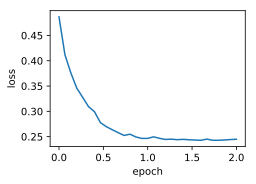

In [2]:
d2lt.train_ch7(adadelta, init_adadelta_states(), {'rho': 0.9}, features,
              labels)

## 简洁实现

通过名称为“Adadelta”的`Optimizer`实例，我们便可使用PyTorch提供的AdaDelta算法。它的超参数可以通过`rho`来指定。

loss: 0.256363, 0.076244 sec per epoch


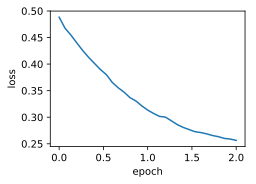

In [3]:
d2lt.train_nn_ch7(optim.Adadelta, {'rho': 0.9}, features, labels)

## 小结

* AdaDelta算法没有学习率超参数，它通过使用有关自变量更新量平方的指数加权移动平均的项来替代RMSProp算法中的学习率。

## 练习

* 调节AdaDelta算法中超参数$\rho$的值，观察实验结果。



## 参考文献

[1] Zeiler, M. D. (2012). ADADELTA: an adaptive learning rate method. arXiv preprint arXiv:1212.5701.

## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/2277)

![](../img/qr_adadelta.svg)